In [1]:
import numpy as np
from pc_kriging import PC_Kriging
from sklearn.gaussian_process import GaussianProcessRegressor # is it needed?
from sklearn.gaussian_process.kernels import RBF # is it needed?
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize

## Reference function

In [55]:
def UQLab(x):
    return x*np.sin(x)
    
# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [array]
    dist=PCK1.distance(x.reshape(1,-1),xn)
    return np.argmin(dist)

Objective function

In [17]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, y, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (y-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

### Creating object

In [12]:
config = {"pol_type": ['legendre']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)

### Creating and evaluating ref function

In [13]:
function = UQLab   #choose the ground truth function

dim = 1       # dimensionality
n = 6   # observations
seed = 0      # fixing seed random number generator

np.random.seed(seed)         #fixing seed random number generator

xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points

#LatinHypercubeSampling-----------------------------------------------
Xdoe=build.space_filling_lhs({'X':[-1,1]}, num_samples = n )   # variables may increase...{'X2':[min2, max2],'X3':[min2, max2]}
#-----------------------------------------------------random Variable 1
# x1mean = 1.5                           
# x1sigma = 1.0
x1min=0
x1max=15
# xn[:,0] = np.random.normal(0, 1, n)
#        
xn[:,0] = np.sort(Xdoe,0).reshape(-1)             
xr[:,0] = PCK1.scalelegendre(xn[:,0], x1min, x1max)
 
#-----------------------------------------------------random Variable 2

# x2mean = 2.5              
# x2sigma = 1.0  

# xn[:,1] = np.random.normal(0, 1, n)                             
# xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma) 

#=====================================================
# Evaluation of observations 
y = function(xr)          #Observations
# y = y[0]

In [10]:
#optimizing kernell-hyperparameters and fitting GP regressor with Scikit-learn package----------------------------
kernel = 1 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(xn, y)
ke= gaussian_process.kernel_
print("kernel 1   :",ke)

kernel 1   : 5.06**2 * RBF(length_scale=0.0432)


## Training the model

In [19]:
#train model -----------------------------------------

# kernel hyperparameters------------------------------
l = 3 #length scale
v = 5/2    #matern coefficient
theta = np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1 = PCK1.train(xn, y, p, theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2

(array([[-15.92373931],
        [ 44.55105983],
        [  9.08836944]]),
 array([[135545.64961953]]))

In [18]:
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


([(3.0, 15.0)], array([3.]), array([3.]), array([3.]))

### Generating prediction points

In [21]:
# model predictions -----------------------------------------

ntest = 200  # test points
seed = 0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XN = np.zeros((int(ntest), dim))  #normalized test points
XR = np.zeros((int(ntest), dim))  #scaled test points 
#variable 1 ---------------------------------------------------
# XN[:,0] = np.random.uniform(-1,1,ntest)
XN[:,0] = np.linspace(-0.99,0.99,ntest)
XR[:,0] = PCK1.scalelegendre(XN[:,0].reshape(-1,), x1min, x1max) 
#variable 2 ---------------------------------------------------
# XN[:,1] = np.random.normal(0,1,ntest)  
# XR[:,1] = PCK1.scalehermite(XN[:,1],x2mean,x2sigma)  

Mtest = function(XR)    #test points
mean1,var1 = PCK1.predict(XN)

### Variance enhancement (LOOcv)

In [87]:
#Generating PCK models for each reduced design of experiments 
PCK_loo = PC_Kriging(config)    # same 'config' as specified in the original model

mean_loo = np.zeros(n)
var_loo = np.zeros(n)

for i in range (0,n):             
    yn_loo =  np.delete(y,[i])                              #y_n-i      leaving element i out the observations 
    xr_loo= np.delete(xr,i).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
    xn_loo= np.delete(xn,i).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

    #training LOO
    modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p, theta) as specified in the original model
     
    #predicting LOO
    mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))
               
e_loo = (y - mean_loo.reshape(-1,dim))**2              #LOO CV squared errors
sumat = np.divide(e_loo,var_loo).reshape(-1,dim)        #vector (e_loo / s_loo) for each observed point

LOOCV=np.zeros(ntest)

for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
    voro = VoronoiCell(XR[k],xr)
    
    LOOCV[k]= var1[k]*(1+sumat[voro])   

In [90]:
z=0    #target value

eff1 = np.zeros(ntest)

eff1 = EFF(np.squeeze(mean1),LOOCV,z)

U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))

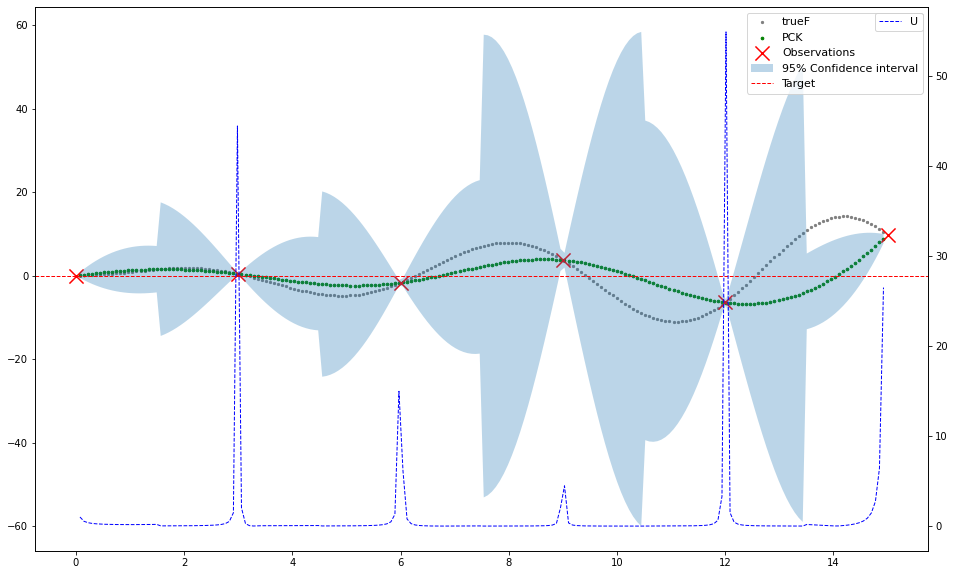

In [92]:
ymin=(mean1 - 1.96*(LOOCV.reshape(-1,1))**0.5)
ymax=(mean1 + 1.96*(LOOCV.reshape(-1,1))**0.5)

# sorting in case of random samples for ploting

ind=np.argsort(np.squeeze(XR))
a,b,c=np.asarray(XR)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

#%matplotlib notebook 
fig, ax1 = plt.subplots(figsize=(16,10))

ax2=ax1.twinx()


# fig = plt.figure(figsize=(15,8))
# ax=fig.add_axes([0,0,1,1])
ax1.scatter(XR,Mtest,label=r"trueF",color='grey',s=5)
# plt.scatter(XR,mean1,label=r"PC trend",color='blue',s=5)
ax1.scatter(XR,mean1,label=r"PCK",color='g',s=7)
ax1.scatter(xr, y, label="Observations",marker="x",color='r',s=200)
ax1.legend(prop={'size': 10})
ax1.fill_between(
    a.ravel(),
    b.ravel(),
    c.ravel(),
    alpha=0.3,
    label=r"95% Confidence interval",
)

# ax2.plot(XR,eff1,label="EFF",linestyle='dashed',linewidth=1,color='k')
ax2.plot(XR,U_f,label="U",linestyle='dashed',linewidth=1,color='b')

ax1.axhline(z,label="Target", color='red', linestyle='dashed',linewidth=1)
ax1.legend(prop={'size': 11})
ax2.legend(prop={'size': 11})
# ax2.set_ylim(0,1)
# plt.xlim([0, 1.75])
# plt.ylim([-20.0, 20.0])

In [ ]:
ymin=(mean1 - 1.96*(var1.reshape(-1,1))**0.5)
ymax=(mean1 + 1.96*(var1.reshape(-1,1))**0.5)

# sorting in case of random samples for ploting

ind=np.argsort(np.squeeze(XR))
a,b,c=np.asarray(XR)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

#%matplotlib notebook 
fig, ax1 = plt.subplots(figsize=(16,10))

ax2=ax1.twinx()


# fig = plt.figure(figsize=(15,8))
# ax=fig.add_axes([0,0,1,1])
ax1.scatter(XR,Mtest,label=r"trueF",color='grey',s=5)
# plt.scatter(XR,mean1,label=r"PC trend",color='blue',s=5)
ax1.scatter(XR,mean1,label=r"PCK",color='g',s=7)
ax1.scatter(xr, y, label="Observations",marker="x",color='r',s=200)
ax1.legend(prop={'size': 10})
ax1.fill_between(
    a.ravel(),
    b.ravel(),
    c.ravel(),
    alpha=0.3,
    label=r"95% Confidence interval",
)

ax2.plot(XR,eff1,label="EFF",linestyle='dashed',linewidth=1,color='k')
# ax2.plot(XR,U_f,label="U",linestyle='dashed',linewidth=1,color='b')

ax1.axhline(z,label="Target", color='red', linestyle='dashed',linewidth=1)
ax1.legend(prop={'size': 11})
ax2.legend(prop={'size': 11})
# ax2.set_ylim(0,1)
# plt.xlim([0, 1.75])
# plt.ylim([-20.0, 20.0])

Function to graph the evolution Theta varying 'length scale'

In [ ]:

def Lscale (l):
    v=5/2
    detR = np.zeros(len(l))
    theta = np.zeros(len(l))
    sig2 = np.zeros(len(l))
    
    N=len(xn)
    

    for i in range(0, len(l)):       
        R = PCK1.matern(xn , xn, l[i], v)
        detR[i] = np.linalg.det(R)
        modelpar2 = PCK1.train(xn, y, p, np.array([l[i],v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
        sig2[i] = modelpar2[1].reshape(-1)
        
        # theta[i] = 0.5*(np.log(detR[i])+ N*np.log(2*np.pi*sig2[i])+ N)

        ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
        FB = modelpar2[2] @ modelpar2[0]
        ins = (y-FB).reshape(-1)
        R_1 = np.linalg.inv(R)
        theta[i] = ((ins.T) @ R_1 @ ins) * (1/N) * (detR[i]**(1/N))

    return theta , detR, sig2

In [ ]:
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)

    modelpar2 = PCK1.train(xn, y, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)

    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = modelpar2[2] @ modelpar2[0]
    ins = (y-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
Graph_bound = np.array([lmin, lmax])
xlength=np.linspace(Graph_bound[0], Graph_bound[1], 1000)
theta, detR, sig2 = Lscale(xlength)


fig = plt.figure(figsize=(15,8))
plt.plot(xlength, theta)
plt.grid()
plt.show

In [ ]:
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

In [ ]:
results['shgo_sobol'] = optimize.shgo(L_Object, bounds, n=200, iters=5,
                                      sampling_method='sobol')
results['shgo_sobol']                               